<center><img src="car.jpg" width=500></center>


Insurance companies invest a lot of time and money into optimizing their pricing and accurately estimating the likelihood that customers will make a claim. In many countries insurance it is a legal requirement to have car insurance in order to drive a vehicle on public roads, so the market is very large!

(`Source: https://www.accenture.com/_acnmedia/pdf-84/accenture-machine-leaning-insurance.pdf`) 

Knowing all of this, On the Road car insurance have requested your services in building a model to predict whether a customer will make a claim on their insurance during the policy period. As they have very little expertise and infrastructure for deploying and monitoring machine learning models, they've asked you to identify the single feature that results in the best performing model, as measured by accuracy, so they can start with a simple model in production.

They have supplied you with their customer data as a csv file called `car_insurance.csv`, along with a table detailing the column names and descriptions below.



## The dataset

| Column | Description |
|--------|-------------|
| `id` | Unique client identifier |
| `age` | Client's age: <br> <ul><li>`0`: 16-25</li><li>`1`: 26-39</li><li>`2`: 40-64</li><li>`3`: 65+</li></ul> |
| `gender` | Client's gender: <br> <ul><li>`0`: Female</li><li>`1`: Male</li></ul> |
| `driving_experience` | Years the client has been driving: <br> <ul><li>`0`: 0-9</li><li>`1`: 10-19</li><li>`2`: 20-29</li><li>`3`: 30+</li></ul> |
| `education` | Client's level of education: <br> <ul><li>`0`: No education</li><li>`1`: High school</li><li>`2`: University</li></ul> |
| `income` | Client's income level: <br> <ul><li>`0`: Poverty</li><li>`1`: Working class</li><li>`2`: Middle class</li><li>`3`: Upper class</li></ul> |
| `credit_score` | Client's credit score (between zero and one) |
| `vehicle_ownership` | Client's vehicle ownership status: <br><ul><li>`0`: Does not own their vehilce (paying off finance)</li><li>`1`: Owns their vehicle</li></ul> |
| `vehcile_year` | Year of vehicle registration: <br><ul><li>`0`: Before 2015</li><li>`1`: 2015 or later</li></ul> |
| `married` | Client's marital status: <br><ul><li>`0`: Not married</li><li>`1`: Married</li></ul> |
| `children` | Client's number of children |
| `postal_code` | Client's postal code | 
| `annual_mileage` | Number of miles driven by the client each year |
| `vehicle_type` | Type of car: <br> <ul><li>`0`: Sedan</li><li>`1`: Sports car</li></ul> |
| `speeding_violations` | Total number of speeding violations received by the client | 
| `duis` | Number of times the client has been caught driving under the influence of alcohol |
| `past_accidents` | Total number of previous accidents the client has been involved in |
| `outcome` | Whether the client made a claim on their car insurance (response variable): <br><ul><li>`0`: No claim</li><li>`1`: Made a claim</li></ul> |

In [1]:
import pandas as pd
from statsmodels.formula.api import logit
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Load data
cars = pd.read_csv("car_insurance.csv")

# Data Exploration
print(cars.info())
print(cars.head())
print(cars.describe(include='all'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10000 non-null  int64  
 1   age                  10000 non-null  int64  
 2   gender               10000 non-null  int64  
 3   driving_experience   10000 non-null  object 
 4   education            10000 non-null  object 
 5   income               10000 non-null  object 
 6   credit_score         9018 non-null   float64
 7   vehicle_ownership    10000 non-null  float64
 8   vehicle_year         10000 non-null  object 
 9   married              10000 non-null  float64
 10  children             10000 non-null  float64
 11  postal_code          10000 non-null  int64  
 12  annual_mileage       9043 non-null   float64
 13  vehicle_type         10000 non-null  object 
 14  speeding_violations  10000 non-null  int64  
 15  duis                 10000 non-null  

In [2]:
# Check and Fill Missing Values
print("\nMissing Values:\n", cars.isnull().sum())
cars["credit_score"].fillna(cars["credit_score"].mean(), inplace=True)
cars["annual_mileage"].fillna(cars["annual_mileage"].mean(), inplace=True)
print("\nAfter Filling Missing Values:\n", cars.isnull().sum())



Missing Values:
 id                       0
age                      0
gender                   0
driving_experience       0
education                0
income                   0
credit_score           982
vehicle_ownership        0
vehicle_year             0
married                  0
children                 0
postal_code              0
annual_mileage         957
vehicle_type             0
speeding_violations      0
duis                     0
past_accidents           0
outcome                  0
dtype: int64

After Filling Missing Values:
 id                     0
age                    0
gender                 0
driving_experience     0
education              0
income                 0
credit_score           0
vehicle_ownership      0
vehicle_year           0
married                0
children               0
postal_code            0
annual_mileage         0
vehicle_type           0
speeding_violations    0
duis                   0
past_accidents         0
outcome                0
d

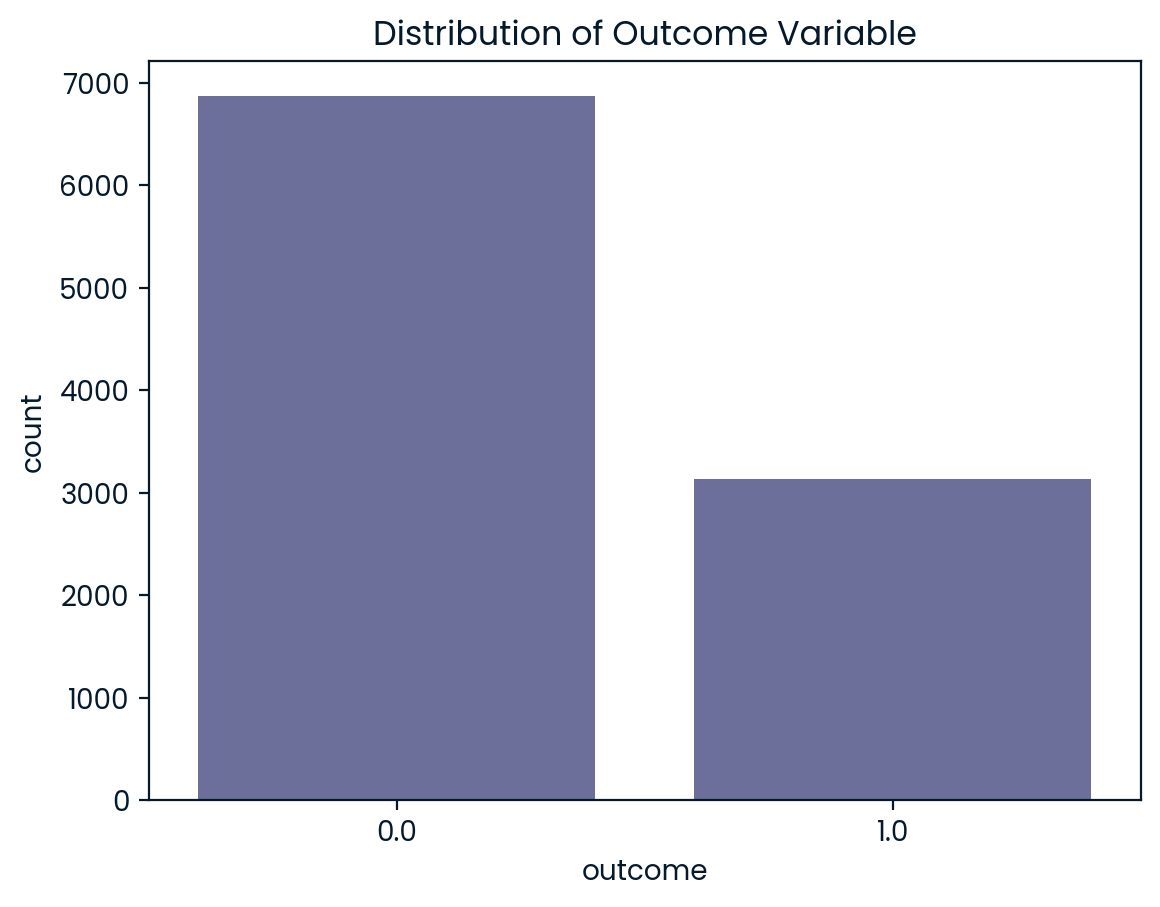

In [3]:
# Visualize Target Variable
sns.countplot(x="outcome", data=cars)
plt.title("Distribution of Outcome Variable")
plt.show()

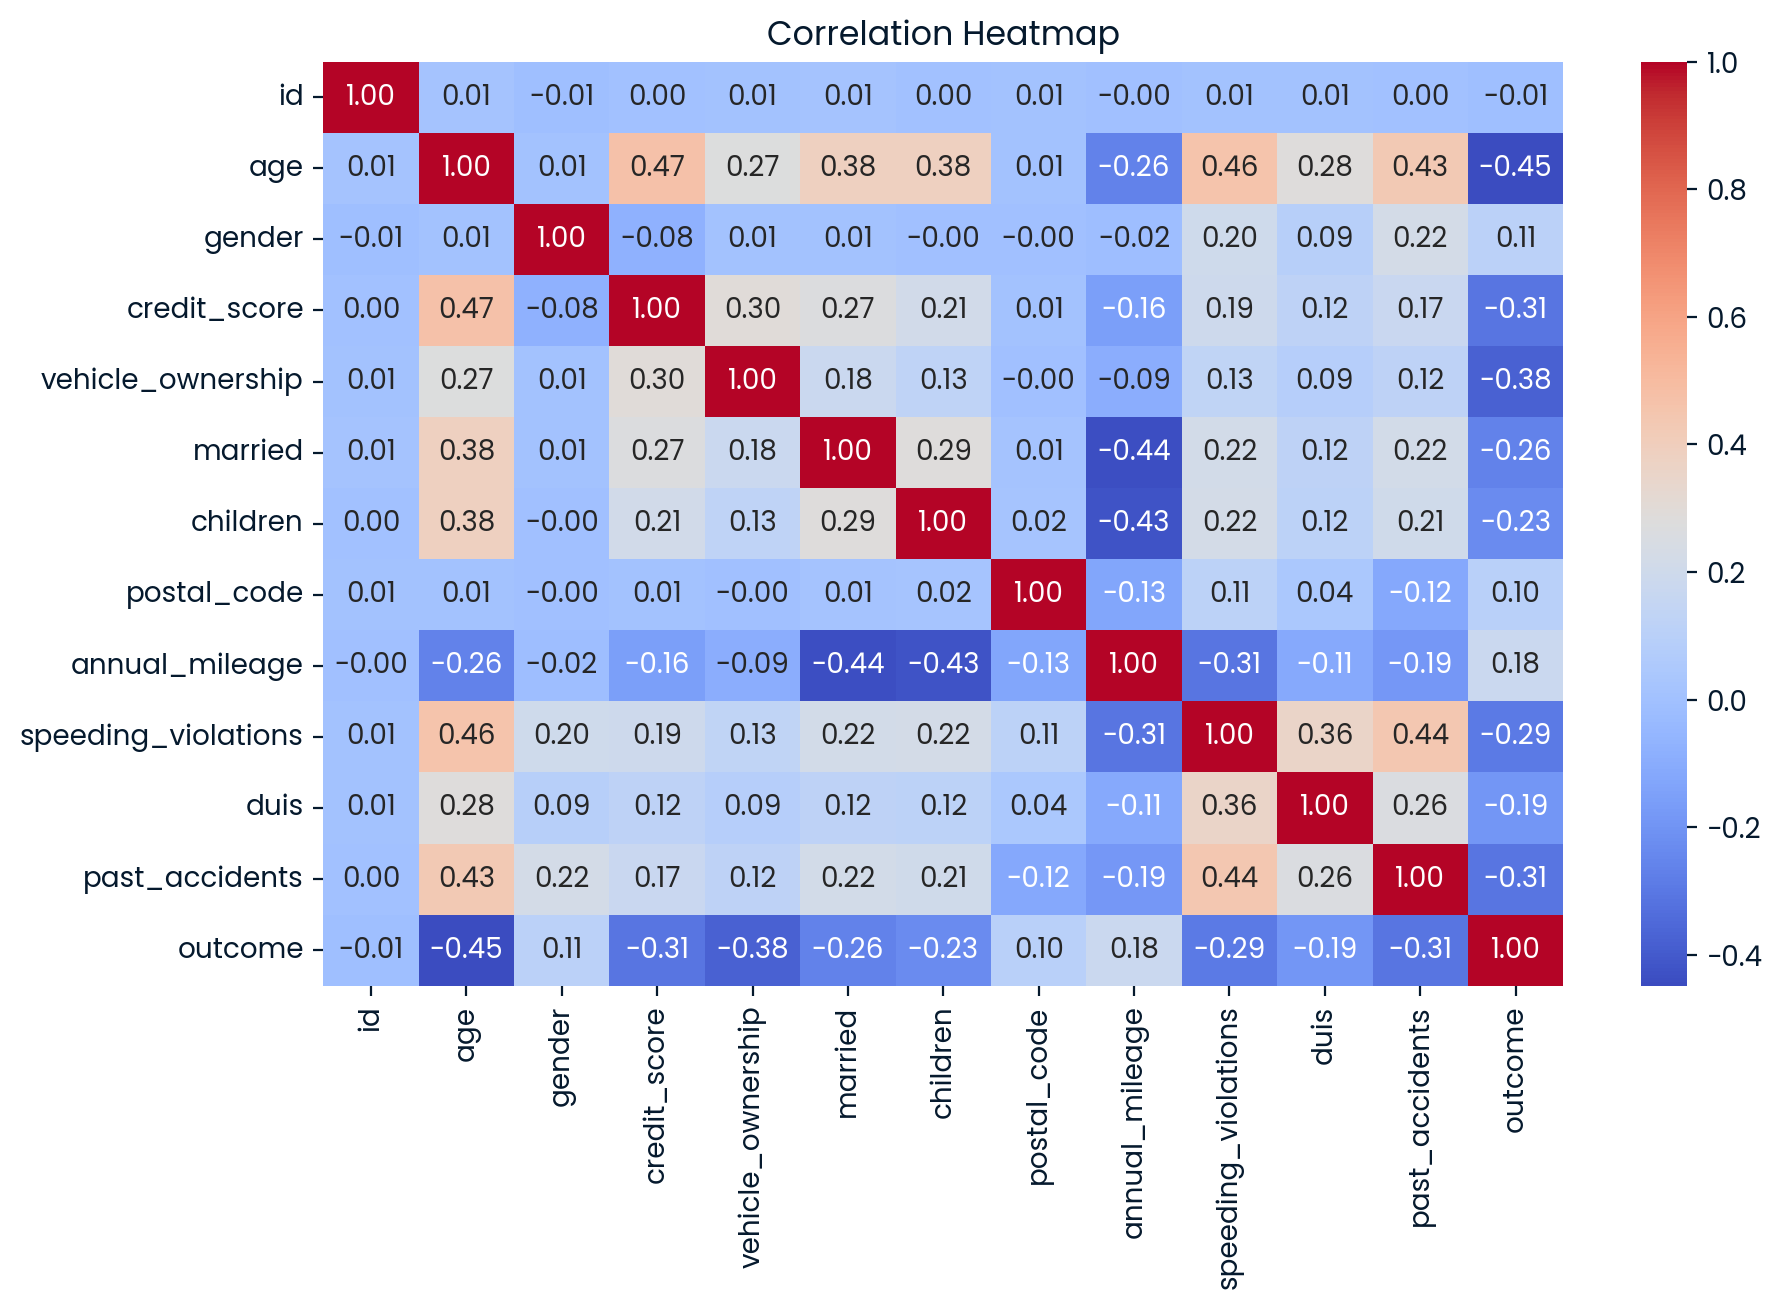

In [4]:
# Correlation Heatmap (Numerical Features Only)
numerical_cols = cars.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(10, 6))
sns.heatmap(cars[numerical_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [5]:
# Drop Irrelevant Columns and Prepare Feature List
irrelevant_columns = ["id", "outcome"]
features = cars.drop(columns=irrelevant_columns).columns


In [6]:
# Analyze Unique Values for Categorical Features
for col in features:
    if cars[col].dtype == 'object':
        print(f"{col} unique values:\n{cars[col].value_counts()}\n")

driving_experience unique values:
0-9y      3530
10-19y    3299
20-29y    2119
30y+      1052
Name: driving_experience, dtype: int64

education unique values:
high school    4157
university     3928
none           1915
Name: education, dtype: int64

income unique values:
upper class      4336
middle class     2138
poverty          1814
working class    1712
Name: income, dtype: int64

vehicle_year unique values:
before 2015    6967
after 2015     3033
Name: vehicle_year, dtype: int64

vehicle_type unique values:
sedan         9523
sports car     477
Name: vehicle_type, dtype: int64



In [7]:
# Logistic Regression Analysis
models = []
accuracies = []
summary_data = []

for col in features:
    model = logit(f"outcome ~ {col}", data=cars).fit(disp=False)
    models.append(model)

    # Calculate Accuracy
    conf_matrix = model.pred_table()
    tn, fp, fn, tp = conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[1, 0], conf_matrix[1, 1]
    acc = (tn + tp) / (tn + fp + fn + tp)
    accuracies.append(acc)

    # Collect Summary Data
    summary_data.append({
        "Feature": col,
        "Odds Ratios": np.exp(model.params),
        "Accuracy": acc
    })

    # Print Detailed Model Summary
    print(f"Feature: {col}")
    print(model.summary())
    print("\nOdds Ratios:\n", np.exp(model.params))
    print("-" * 50)


Feature: age
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9998
Method:                           MLE   Df Model:                            1
Date:                Wed, 01 Jan 2025   Pseudo R-squ.:                  0.1768
Time:                        05:13:38   Log-Likelihood:                -5117.9
converged:                       True   LL-Null:                       -6217.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6730      0.039     17.161      0.000       0.596       0.750
age           -1.1356      0.028    -40.890      0.000      -1.190      -1.081

Odds Ratios:
 Intercept    1.960188
ag

In [8]:
# Find the best feature
best_feature_index = accuracies.index(max(accuracies))
best_feature_name = features[best_feature_index]
best_accuracy = max(accuracies)

# Create and display the best feature DataFrame
best_feature_df = pd.DataFrame({
    "best_feature": [best_feature_name],
    "best_accuracy": [best_accuracy]
})
print("\nBest Feature and Accuracy:\n", best_feature_df)

best_accuracy = max(accuracies)
best_model = models[best_feature_index]

print(f"\nBest Feature: {best_feature_name} with Accuracy: {best_accuracy:.2f}")
print("\nBest Feature Model Summary:\n")
print(best_model.summary())



Best Feature and Accuracy:
          best_feature  best_accuracy
0  driving_experience         0.7771

Best Feature: driving_experience with Accuracy: 0.78

Best Feature Model Summary:

                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9996
Method:                           MLE   Df Model:                            3
Date:                Wed, 01 Jan 2025   Pseudo R-squ.:                  0.2487
Time:                        05:14:05   Log-Likelihood:                -4670.9
converged:                       True   LL-Null:                       -6217.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------

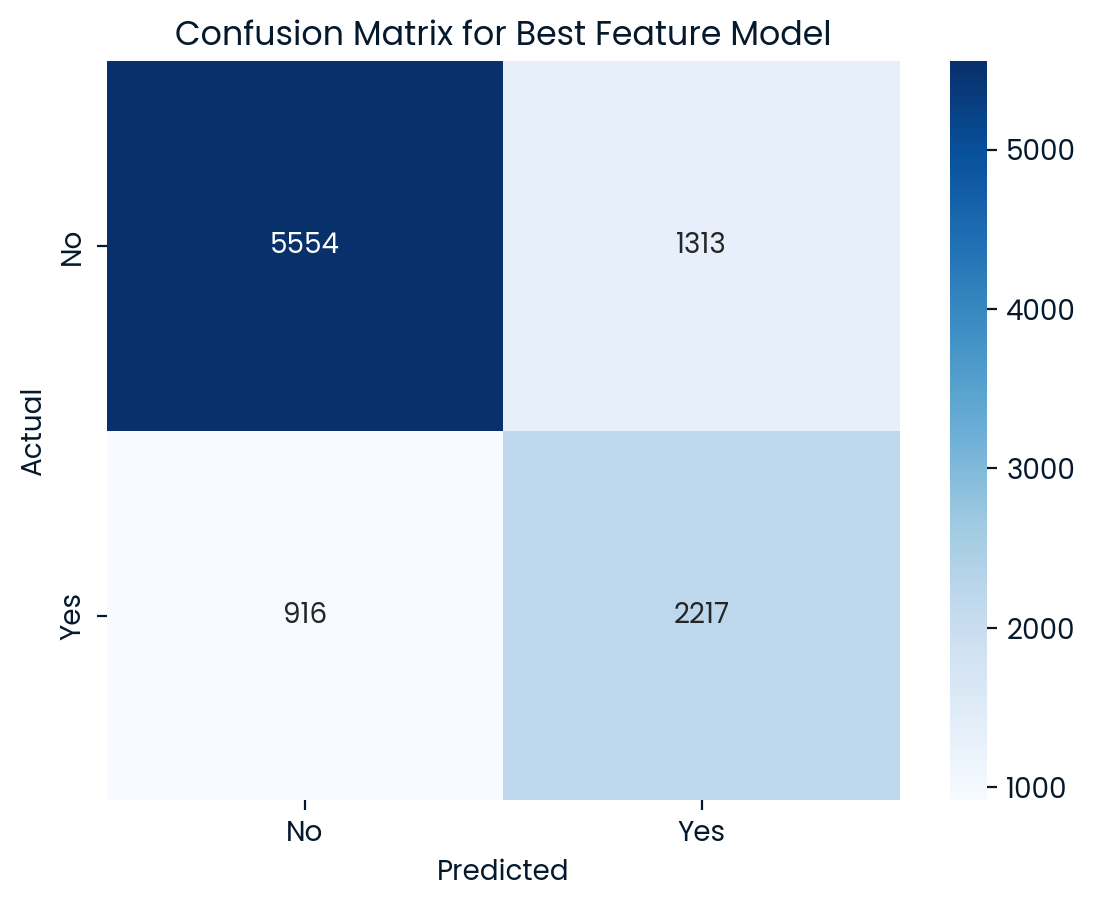

Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.81      0.83      6867
         1.0       0.63      0.71      0.67      3133

    accuracy                           0.78     10000
   macro avg       0.74      0.76      0.75     10000
weighted avg       0.79      0.78      0.78     10000

Accuracy Score: 0.7771


In [9]:
# Visualize Performance of the Best Feature
y_pred = best_model.predict(cars[best_feature_name])
y_pred_class = (y_pred >= 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(cars["outcome"], y_pred_class)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Best Feature Model")
plt.show()

# Performance Metrics
print("Classification Report:\n", classification_report(cars["outcome"], y_pred_class))
print("Accuracy Score:", accuracy_score(cars["outcome"], y_pred_class))


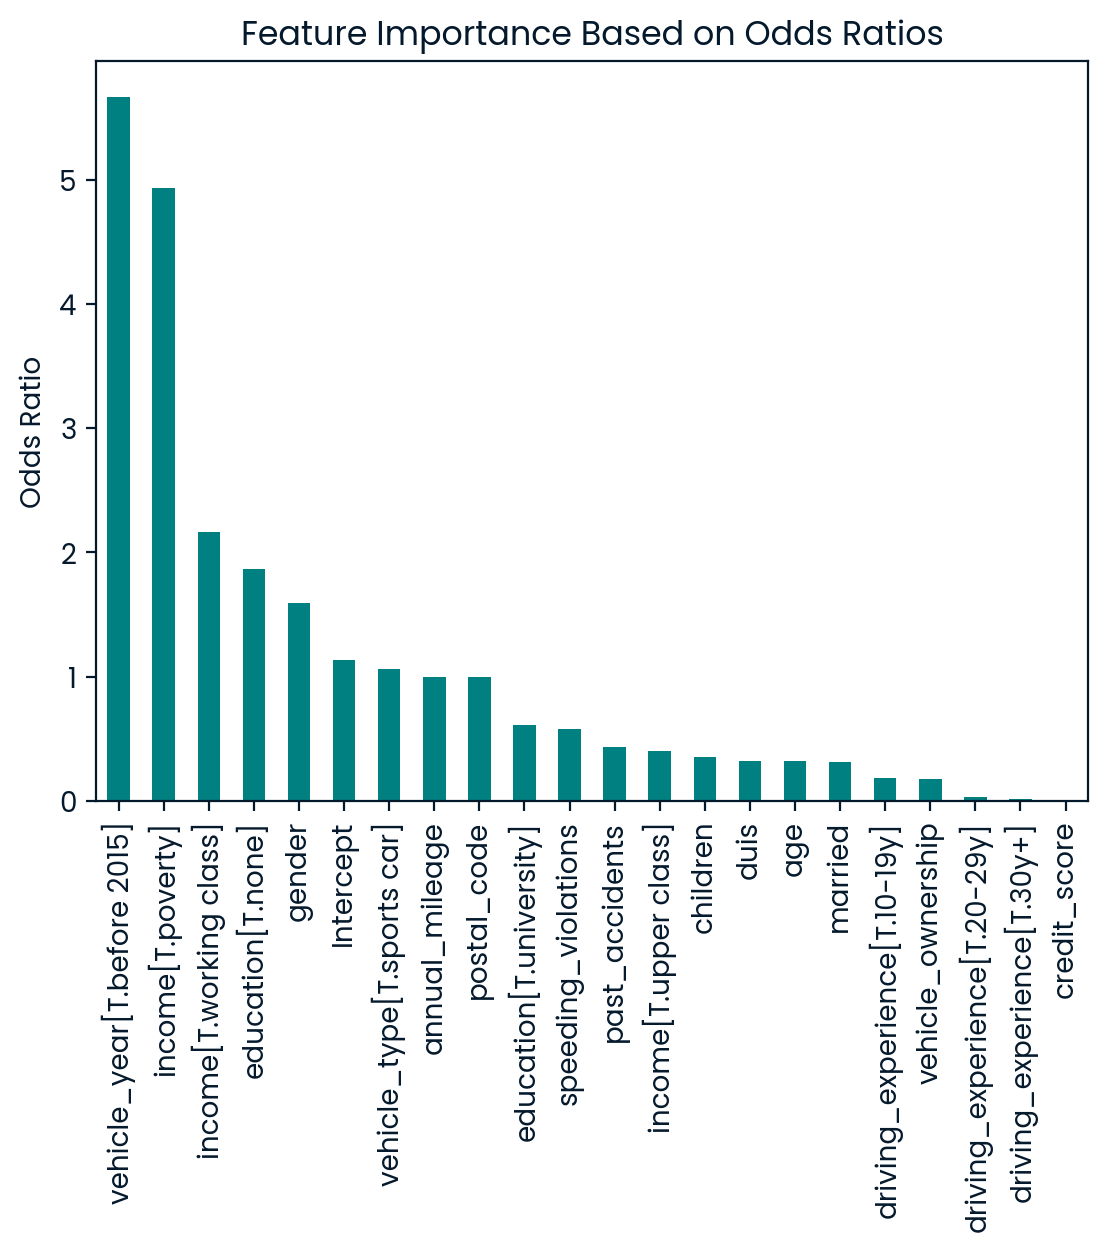

0-9y      3530
10-19y    3299
20-29y    2119
30y+      1052
Name: driving_experience, dtype: int64


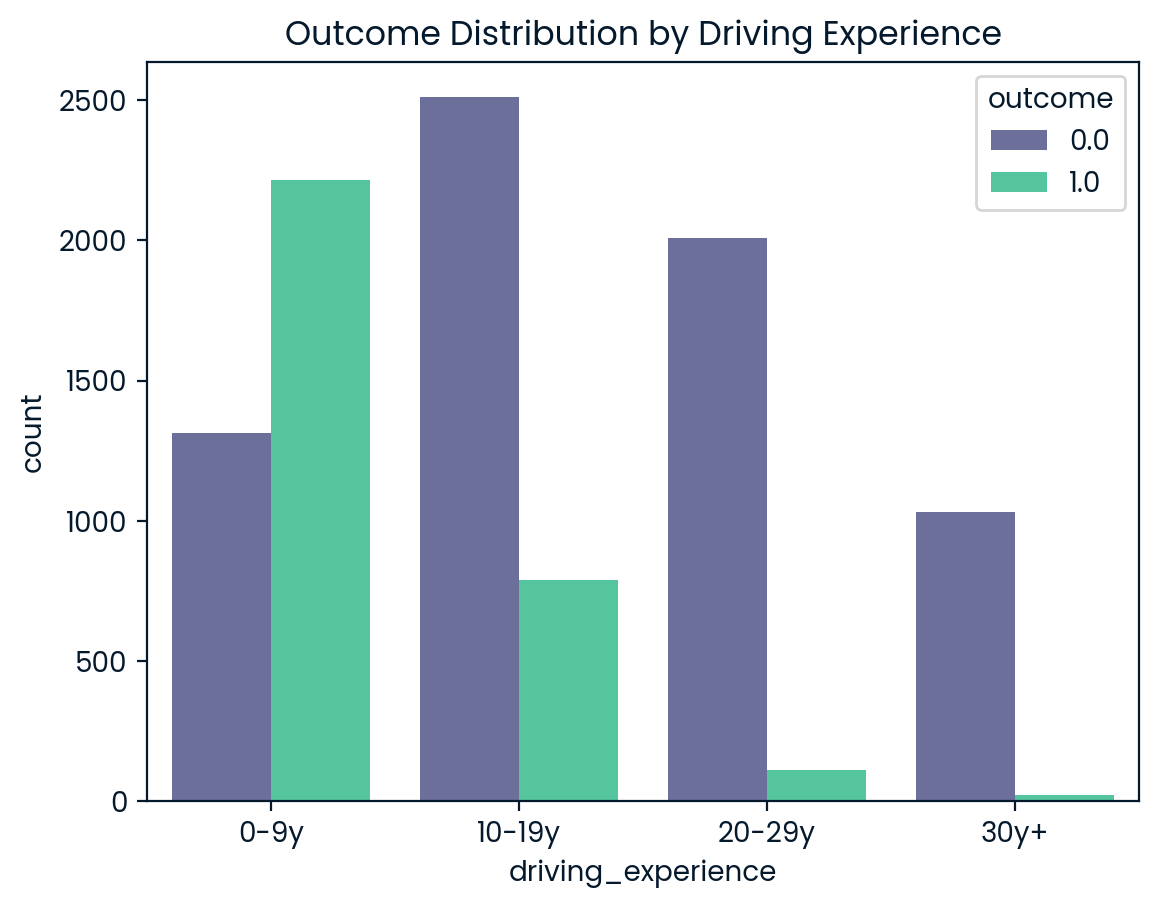

In [12]:
# Visualize Feature Importance for All Features
odds_ratios = pd.DataFrame({
    feature: np.exp(models[i].params) for i, feature in enumerate(features)
})
odds_ratios.mean(axis=1).sort_values(ascending=False).plot(kind="bar", title="Feature Importance Based on Odds Ratios", color="teal")
plt.ylabel("Odds Ratio")
plt.show()

# Driving Experience Analysis
print(cars['driving_experience'].value_counts())
sns.countplot(x='driving_experience', hue='outcome', data=cars)
plt.title("Outcome Distribution by Driving Experience")
plt.show()